Imports


In [94]:
# Install haversine if required
# !pip install haversine

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import geopy.distance
import haversine as hs
from haversine import Unit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from tkinter import filedialog

Load data


In [95]:
# Load dataset

# VS Code compatable
# file_path = filedialog.askopenfilename(title="Select the CSV file")
# df = pd.read_csv(file_path)

# Colab compatable ie. dataset must be uploaded to colab session notebook
df = pd.read_csv('Dataset2.csv')

Drop column 1 and 2

In [96]:
# Remove unnecessary columns
df.drop(['key'], axis=1, inplace=True)
df.dropna(axis=0,inplace=True)

In [97]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Missing values in the dataset:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [98]:
# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(df.head())

print('\r')

# Display the fields of the dataset
print("\nFields of the dataset:")
print(df.columns)


First few rows of the dataset:
   fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1         16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303   
2          5.7  2011-08-18 00:35:00 UTC        -73.982738        40.761270   
3          7.7  2012-04-21 04:30:42 UTC        -73.987130        40.733143   
4          5.3  2010-03-09 07:51:00 UTC        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278                1  
1         -73.979268         40.782004                1  
2         -73.991242         40.750562                2  
3         -73.991567         40.758092                1  
4         -73.956655         40.783762                1  


Fields of the dataset:
Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude'

Extract hours from date time

In [99]:
# Convert 'pickup_datetime' to a datetime data type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract the date, time, and other components
df['hours'] = df['pickup_datetime'].dt.hour

In [100]:
df.drop('pickup_datetime', axis=1, inplace=True)
df.drop('passenger_count', axis=1, inplace=True)

Remove latitude and longitude values that are not in range

In [101]:
# Drop the rows where the latitude and longitude are not in range
condition = df[
    (df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180) |
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)
].index

df.drop(condition, inplace=True)

Calculate Distance

In [102]:
# Calculate the distance between pickup and dropoff locations
longitude, latitude = [], []

longitude.append(df["pickup_longitude"].tolist())
longitude.append(df["dropoff_longitude"].tolist())
latitude.append(df["pickup_latitude"].tolist())
latitude.append(df["dropoff_latitude"].tolist())

# Find the distance in miles
distance = [hs.haversine((latitude[1][i], longitude[1][i]), (latitude[0][i], longitude[0][i]), unit=Unit.KILOMETERS)
              for i in range(len(longitude[0]))]

# Append the new distance column to the dataset
df['distance'] = distance

In [103]:
# Remove old longitute and latitude fields
df.drop(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'] , inplace=True , axis= 1)
df.head()

,fare_amount,hours,distance
0,4.5,17,1.030765
1,16.9,16,8.450145
2,5.7,0,1.389527
3,7.7,4,2.799274
4,5.3,7,1.999160


Visualize the distribution of 'hours'

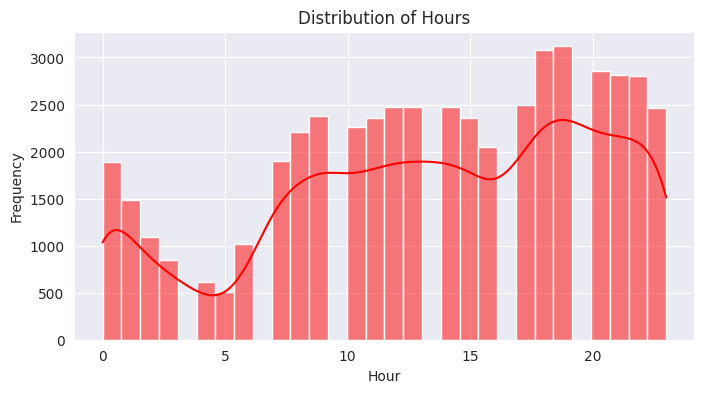

In [104]:
plt.figure(figsize=(8, 4))
sns.set_style(style='darkgrid')
sns.histplot(df['hours'], bins=30, kde=True, color='red')
plt.title('Distribution of Hours')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

Remove Outliers

In [105]:
# Drop the rows where the fare amount is <=0 and distance is <=0
df.drop(df[df['fare_amount']<=0].index,inplace=True)
df.drop(df[df['distance']<=0].index,inplace=True)

# Drop distance and fair amount outliers
df.drop(df[df['distance']>60].index,inplace=True)
df.drop(df[df['fare_amount']>100].index,inplace=True)

# Drop unrealistic fair amounts and distance travelled
df.drop(df[(df['fare_amount']>=100) & (df['distance']<=1)].index,inplace=True)
df.drop(df[(df['fare_amount']<=100) & (df['distance']>=100)].index,inplace=True)

Distance vs fare amount graph

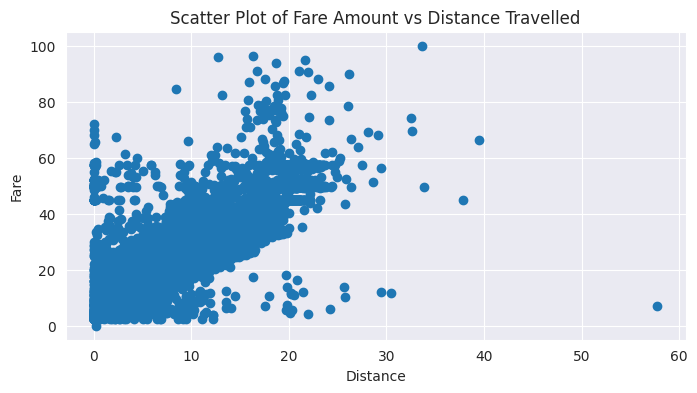

In [106]:
plt.figure(figsize=(8, 4))
plt.scatter(df['distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("Fare")
plt.title('Scatter Plot of Fare Amount vs Distance Travelled')
plt.show()

In [107]:
x = df.drop(['fare_amount'],axis = 1)
y = df['fare_amount'].values.reshape(-1, 1)

In [108]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

Standardize values

In [109]:
y_std = std.fit_transform(y)
x_std = std.fit_transform(x)

Model Evaluation

In [110]:
# Split dataset into Training and Testing data
x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.2, random_state=42)

1. Linear Regression Model


In [111]:
# Create linear model and train
from sklearn.linear_model import LinearRegression
LR = LinearRegression()

# Train the model
LR.fit(x_train,y_train)

# Use model to predict on test data
LR_y_predict = LR.predict(x_test)

Linear Regression Accuracy


In [112]:
# Calculate regression metrics
mse = mean_squared_error(y_test, LR_y_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, LR_y_predict)
r2 = r2_score(y_test, LR_y_predict)

print("Linear Regression Evaluation Metrics:")
print(f"-Mean Squared Error (MSE): {mse:.6f}")
print(f"-Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"-Mean Absolute Error (MAE): {mae:.6f}")
print(f"-R-squared (R^2): {r2:.6f}")

Linear Regression Evaluation Metrics:
-Mean Squared Error (MSE): 0.216176
-Root Mean Squared Error (RMSE): 0.464948
-Mean Absolute Error (MAE): 0.251807
-R-squared (R^2): 0.786212


2. Random Forest Regression Model

In [113]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(x_train, y_train.ravel())

# Make predictions on the test set
RF_y_pred = rf_regressor.predict(x_test)

Random Forest Accuracy

In [114]:
# Calculate regression metrics
mse = mean_squared_error(y_test, RF_y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, RF_y_pred)
r2 = r2_score(y_test, RF_y_pred)

print("Random Forest Regression Evaluation Metrics:")
print(f"-Mean Squared Error (MSE): {mse:.6f}")
print(f"-Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"-Mean Absolute Error (MAE): {mae:.6f}")
print(f"-R-squared (R^2): {r2:.6f}")

Random Forest Regression Evaluation Metrics:
-Mean Squared Error (MSE): 0.235361
-Root Mean Squared Error (RMSE): 0.485140
-Mean Absolute Error (MAE): 0.274146
-R-squared (R^2): 0.767240


3. Gradiant Boosting Regression Model

In [115]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

# Train the model
gb_regressor.fit(x_train, y_train.ravel())

# Make predictions on the test set
GB_y_pred = gb_regressor.predict(x_test)

Gradient Boosting Accuracy

In [116]:
# Calculate regression metrics
mse = mean_squared_error(y_test, GB_y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, GB_y_pred)
r2 = r2_score(y_test, GB_y_pred)

print("Gradient Boosting Regression Evaluation Metrics:")
print(f"-Mean Squared Error (MSE): {mse:.6f}")
print(f"-Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"-Mean Absolute Error (MAE): {mae:.6f}")
print(f"-R-squared (R^2): {r2:.6f}")

Gradient Boosting Regression Evaluation Metrics:
-Mean Squared Error (MSE): 0.192011
-Root Mean Squared Error (RMSE): 0.438190
-Mean Absolute Error (MAE): 0.240686
-R-squared (R^2): 0.810111


Create a Dataframe of Actual vs Predicted fare values for each Regression technique

In [117]:
# Create a dictionary with all predictions
df = {'Actual': y_test[:25], 'Predicted (LR)': LR_y_predict[:25], 'Predicted (RF)': RF_y_pred[:25], 'Predicted (GB)': GB_y_pred[:25]}

# Print the tabulated results
from tabulate import tabulate
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

+------------+------------------+------------------+------------------+
|     Actual |   Predicted (LR) |   Predicted (RF) |   Predicted (GB) |
|------------+------------------+------------------+------------------|
| -0.260535  |       -0.189446  |      -0.010785   |       -0.164209  |
|  0.339981  |        0.190689  |       0.27713    |        0.238652  |
|  0.554451  |        0.0234273 |       0.0702846  |        0.0541261 |
|  1.54101   |        1.47645   |       1.72399    |        1.88685   |
| -0.174747  |       -0.480061  |      -0.554359   |       -0.461288  |
| -0.678752  |       -0.555618  |      -0.591677   |       -0.548556  |
|  0.286363  |        0.380477  |       0.097844   |        0.212185  |
|  0.589838  |       -0.233302  |      -0.494308   |       -0.249794  |
| -0.0353418 |       -0.25453   |      -0.194907   |       -0.211316  |
|  0.382875  |        0.516056  |       0.644635   |        0.39046   |
| -0.346323  |       -0.196613  |      -0.138502   |       -0.24

Actual vs Predicted

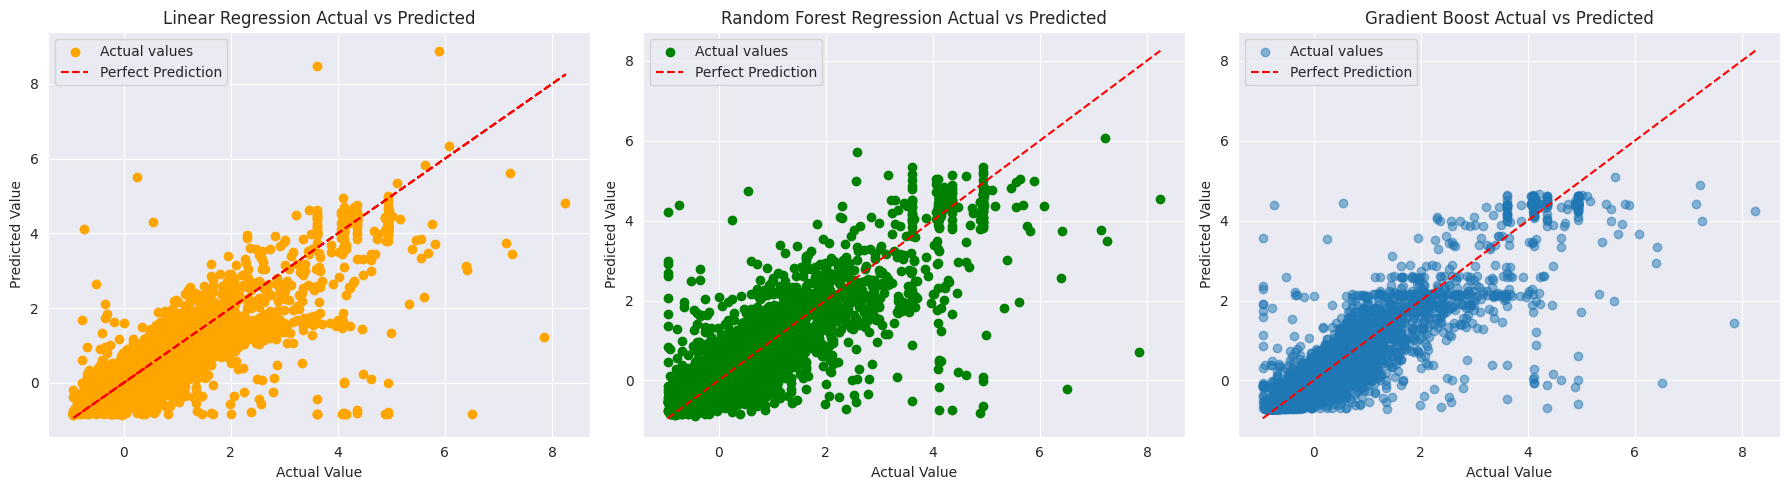

In [118]:
import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Actual vs. Predicted scatter plot
ax1.scatter(y_test, LR_y_predict, color='orange', label='Actual values')
ax1.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')
ax1.set_xlabel('Actual Value')
ax1.set_ylabel('Predicted')
ax1.set_title('Linear Regression Actual vs Predicted')
ax1.legend()
ax1.grid(True)

# Residuals plot
ax2.scatter(y_test, RF_y_pred, color='green', label='Actual values')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
ax2.set_xlabel('Actual Value')
ax2.set_ylabel('Predicted')
ax2.set_title('Random Forest Regression Actual vs Predicted')
ax2.legend()
ax2.grid(True)

# Histogram of residuals
ax3.scatter(y_test, GB_y_pred, alpha=0.5, label='Actual values')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
ax3.set_xlabel('Actual Value')
ax3.set_ylabel('Predicted')
ax3.set_title('Gradient Boost Actual vs Predicted')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

In [119]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# Assuming you have your feature matrix X and target variable y
y_train = y_train.ravel()
# Linear Regression
lr = LinearRegression()
lr_scores = cross_val_score(lr, x_train, y_train, cv=5)
lr_mean_accuracy = lr_scores.mean()
print("-Linear Regression Cross-Validation Accuracy:", lr_mean_accuracy)

rf = RandomForestRegressor()
rf_score = cross_val_score(rf, x_train, y_train, cv=5)
rf_mean_accuracy = rf_score.mean()
print("-Random Forest Cross-Validation Accuracy:", rf_mean_accuracy)

gb = GradientBoostingRegressor()
gb_score = cross_val_score(rf, x_train, y_train, cv=5)
gb_mean_accuracy = gb_score.mean()
print("-Gradiant Boosting Cross-Validation Accuracy:", gb_mean_accuracy)

Linear reg Cross-Validation Accuracy: 0.7798879087778601
Random Forest Cross-Validation Accuracy: 0.7582770538949829
Gradiant Boosting Cross-Validation Accuracy: 0.7584783847240412
